In [62]:
using DataFrames, Statistics, Plots, Measures, CSV

### Zadania
 
1.
 
2. 

3.  Użyć aproksymacji odpowiednimi wielomianami, które najlepiej pasują do zależności czasowych każdego z algorytmów. Stopień wielomianu powinien zgadzać się z teoretyczną złożonoscią. Dodać wykresy uzyskanych wielomianów do wcześniejszych wykresów. **(1 pkt)** Do analizy danych można użyć wybranego narzędzia (Julia, R)

4. Pokazać zniwelowanie efektu Rungego  poprzez użycie wsparcia dla wielomianów Czebyszewa w pakiecie Polynomials. Wymagany wykres. **(1 pkt)**

5. Przybliżenie Pade jest często lepsze niż rozwinięcie w szereg Taylora przy aproksymowaniu funkcji, które posiadają osobliwości. Korzystając ze wsparcia dla aproksymacji Pade w pakiecie Polynomials pokazać dowolny przykład (wraz z wykresem), gdzie takie przybliżenie faktycznie jest lepsze. Można odtworzyć wykres z wykładu albo zainspirować się przykładowym artykułem https://www.hindawi.com/journals/ijcm/2014/587430/ **(1 pkt)**


## Zad1 
Uruchomić 
   - `naive_multiplication(A,B)`, 
   - `better_multiplication(A,B)` 
   - mnożenie BLAS w Julii (`A*B`) 

    dla coraz większych macierzy kwadratowych i zmierzyć czasy. Narysować wykres zależyności czasu od rozmiaru macierzy wraz z słupkami błędów. Wszystkie trzy metody powinny być na jednym wykresie. **(1pkt)**. Do analizy danych można użyć wybranego narzędzia (Julia, R)

In [63]:
# mnożenie macierzy - wersja naiwna
function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    return C
end

naive_multiplication (generic function with 1 method)

In [64]:
function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    return C
end

better_multiplication (generic function with 1 method)

In [65]:
# A*B

In [66]:
df = DataFrame(Nodes=Int[],Naive=Float64[],Better=Float64[], Lib = Float64[])
for n in 5:50:505
    A = rand(n, n);
    B = rand(n, n);
    for j in 1:11
        naive_AB, naive_t = @timed naive_multiplication(A,B)
        better_AB, better_t = @timed better_multiplication(A,B)
        lib_AB, lib_t = @timed A*B
        if j > 1
            push!(df,hcat([n],naive_t, better_t, lib_t))
        end
    end
end

In [67]:
df2 = combine(groupby(df, :Nodes), :Naive => mean, :Better => mean, :Lib => mean, :Naive => std, :Better => std, :Lib => std)
println(df2)

11×7 DataFrame
 Row │ Nodes  Naive_mean  Better_mean  Lib_mean    Naive_std    Better_std   Lib_std     
     │ Int64  Float64     Float64      Float64     Float64      Float64      Float64     
─────┼───────────────────────────────────────────────────────────────────────────────────
   1 │     5  4.8e-7       3.9e-7      5.1e-7      6.32456e-8   7.37865e-8   8.75595e-8
   2 │    55  0.00080215   0.00027149  4.596e-5    0.000276274  8.99131e-5   2.42721e-5
   3 │   105  0.00474574   0.00141006  0.0005915   0.000178733  0.000141596  0.000217464
   4 │   155  0.0163377    0.00456037  0.00072082  0.000889336  0.000537877  0.00025607
   5 │   205  0.0374992    0.0104159   0.00110868  0.00157909   0.0012864    0.000269403
   6 │   255  0.0733936    0.019251    0.00136288  0.00158865   0.00115268   0.000844831
   7 │   305  0.126371     0.0321805   0.00192984  0.00224892   0.00213355   0.000627791
   8 │   355  0.204433     0.0512844   0.00289461  0.00480615   0.00232224   0.00105794
   9 │ 

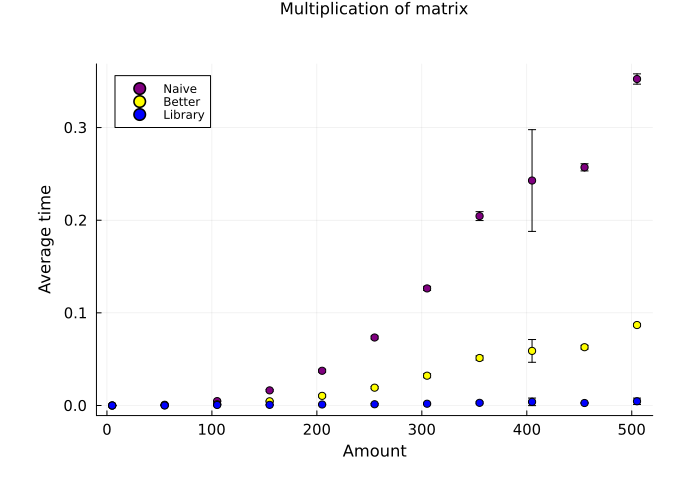

In [68]:
scatter(
    df2.Nodes, 
    size = (700, 500), 
    margin=10mm,
    xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    xlabel = "Amount",
    ylabel = "Average time",
    [df2.Naive_mean, df2.Better_mean, df2.Lib_mean], 
    title = "Multiplication of matrix", 
    label = ["Naive"  "Better" "Library"],
    color = [:purple :yellow :blue],
    yerr = [df2.Naive_std df2.Better_std df2.Lib_std], 
    legend = true
)

## ZAD 2
Napisać w języku C:
   - naiwną metodę mnożenia macierzy kwadratowych (wersja 1) 
   - ulepszoną wersję za pomocą zamiany pętli metodę mnożenia macierzy(wersja 2), pamiętając, że w C macierz przechowywana jest wierszami (row major order tzn A11,A12, ..., A1m, A21, A22,...,A2m, ..Anm), inaczej niż w Julii ! 
   - skorzystać z  możliwości BLAS poziom 3 dostępnego w GSL  (przykład uzycia https://www.gnu.org/software/gsl/doc/html/blas.html#examples )
    
    Należy porównywać działanie tych trzech algorytmow bez włączonej opcji optymalizacji kompilatora. Przedstawić wyniki na jednym wykresie tak jak w p.1. (osobno niż p.1). **(1 pkt)**
    
    *(Dla chętnych)* sprawdzić, co się dzieje, jak włączymy optymalizację kompilatora i dodać do wykresu. 
Do analizy danych można użyć wybranego narzędzia (Julia, R)

In [69]:
mydata=CSV.read(input, delim=",",DataFrame)
c_data = combine(groupby(mydata,:1),:2 => mean => :m1,:2=> std => :s1, :3 => mean => :m2, :3 => std => :s2, :4 => mean => :m3, :4 => std => :s3)
print(c_data)

11×7 DataFrame
 Row │ size   m1         s1           m2         s2           m3         s3          
     │ Int64  Float64    Float64      Float64    Float64      Float64    Float64     
─────┼───────────────────────────────────────────────────────────────────────────────
   1 │     5  0.0        0.0          0.0        0.0          3.0e-7     9.48683e-7
   2 │    55  0.0001216  1.2222e-5    0.0001283  3.23833e-5   1.2e-5     3.49603e-6
   3 │   105  0.0008095  3.47187e-5   0.0008142  4.97746e-5   8.58e-5    2.03022e-5
   4 │   155  0.0027656  0.000280179  0.0927415  0.284571     0.0002725  5.56821e-5
   5 │   205  0.0960199  0.284554     0.0059265  0.000175053  0.0005609  4.9287e-5
   6 │   255  0.102661   0.284565     0.101425   0.284603     0.0010588  4.60043e-5
   7 │   305  0.199684   0.37975      0.289781   0.434153     0.0017743  8.66731e-5
   8 │   355  0.198951   0.379222     0.198526   0.379367     0.0017086  0.000130466
   9 │   405  0.207313   0.37927      0.297261   0.4351

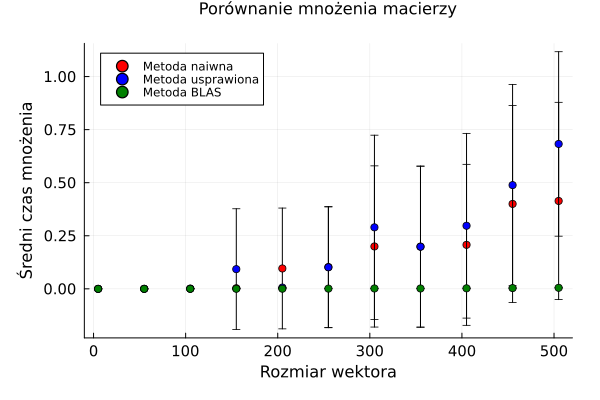

In [70]:
scatter(
    c_data.size, 
    margin=5mm,xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    xlabel = "Amount",
    ylabel = "Average time",
    [c_data.m1,c_data.m2,c_data.m3], 
    title = "Multiplication of matrix in C", 
    legend_position = :topleft, 
    label = ["Naive" "Better" "BLAS"], 
    color = [:red :blue :green],
    yerr = [c_data.s1 c_data.s2 c_data.s3]
)